# Comment démasquer les fraudeurs ? - Challenge BNP PF

## 0. Introduction

Nous avons choisi de participer au challenge Data proposé par BNP Paribas Personal Finance, qui consiste à résoudre le problème de détection de fraudeurs en utilisant le panier client comme source de données. Chaque client est identifié par un ID, et une variable binaire indique si le client est un fraudeur ou non. Nous sommes donc confrontés à un problème de classification.
    
Pour aborder ce problème, nous avons commencé par réaliser une étude exploratoire approfondie des données, en prenant en compte le volume important du dataset proposé par BNP (92 790 observations et 147 colonnes). Cette étape nous a permis de mieux comprendre les colonnes et le fonctionnement du dataset, ainsi que d'identifier les facteurs pertinents et non pertinents dans la détection de la fraude.

Ensuite, nous avons dû transformer le dataset initial pour construire des features quantitatives, car celui-ci était principalement constitué de variables qualitatives. Cette étape était cruciale pour exploiter pleinement les données et les utiliser dans notre modèle.

Enfin, nous avons construit plusieurs modèles de machine learning, tels que SVM, Kmeans, Random Forest, régression logistique et soft voting classifier. Pour cela, nous nous sommes inspiré des notebooks vus en cours. Cependant, comme vous le verrez les résultats obtenus sont mitigés. Même en réalisant un under-sampling pour équilibrer le nombre d'observations de fraude et de non-fraude, notre modèle n'a pas réussi à prédire de manière idéale les fraudes.

En conclusion, nous avons comparé les résultats de nos modèles en utilisant plusieurs métriques, dont les scores PR auc proposés par le challenge et l'accuracy, ainsi que d'autres métriques qui nous semblaient pertinentes. 

L’exucution complète du code est chronophage, nous avions une réelle volonté de ne pas réduire de trop le dataset pour ne pas limité l’apprentissage de notre modèle. De plus, les essaie pour trouver les hyper paramètres sont eux aussi couteux en temps.


In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
import re

warnings.filterwarnings('ignore')

In [27]:
df_X_train = pd.read_csv('X_train_G3tdtEn.csv')
df_Y_train = pd.read_csv('Y_train_2_XPXJDyy.csv')

## 1. Analyse exploratoire de données 

Tout d'abord, nous allons nous concentrer sur l'analyse de notre dataset de panier client (df_X_train). Nous avons d'ores et déjà identifié les difficultés majeures du projet : la taille du dataset et le fait que les variables soit qualitatives. Avant de réalisé des stats descriptive et de nettoyer le dataset , nous estimons qu'il est essentiel de réaliser une analyse approfondie de ce dernier afin de bien le comprendre et de déterminer les colonnes qui pourraient potentiellement être supprimées.

De plus, nous avons choisi de nous concentrer sur les cas de fraude de clients sur un panier d'articles. Par conséquent, l'analyse des types de paniers (marques présentes, produits achetés, montants dépensés, etc.) peut nous fournir des premières indications avant la création de notre dataset de features.

In [4]:
df_X_train.head()

,ID,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,Nbr_of_prod_purchas16,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items
0,85517,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,51113,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,83008,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,78712,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,77846,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [5]:
df_X_train.shape[0]

92790

In [6]:
df_X_train.columns

Index(['ID', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7',
       'item8', 'item9',
       ...
       'Nbr_of_prod_purchas16', 'Nbr_of_prod_purchas17',
       'Nbr_of_prod_purchas18', 'Nbr_of_prod_purchas19',
       'Nbr_of_prod_purchas20', 'Nbr_of_prod_purchas21',
       'Nbr_of_prod_purchas22', 'Nbr_of_prod_purchas23',
       'Nbr_of_prod_purchas24', 'Nb_of_items'],
      dtype='object', length=146)

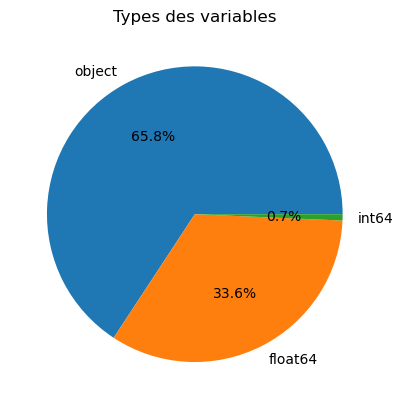

In [9]:
# Regardons le différents types de varibles présentes dans notre base de donnée

var_count = df_X_train.dtypes.value_counts()
plt.pie(var_count, labels=var_count.index.map(str), autopct='%1.1f%%')
plt.title("Types des variables")
plt.show()

In [10]:
#Regardons un peu la répartition des données dans le dataset.

nb_NaN=df_X_train.isnull().sum().sort_values(ascending=False)
df_null=pd.DataFrame({'nbre de NaN' : nb_NaN,'% des NaN':(nb_NaN/df_X_train.shape[0])*100})
df_null

,nbre de NaN,% des NaN
make24,92747,99.953659
goods_code24,92747,99.953659
cash_price24,92747,99.953659
Nbr_of_prod_purchas24,92747,99.953659
item24,92747,99.953659
...,...,...
Nbr_of_prod_purchas1,0,0.000000
goods_code1,0,0.000000
item1,0,0.000000
cash_price1,0,0.000000


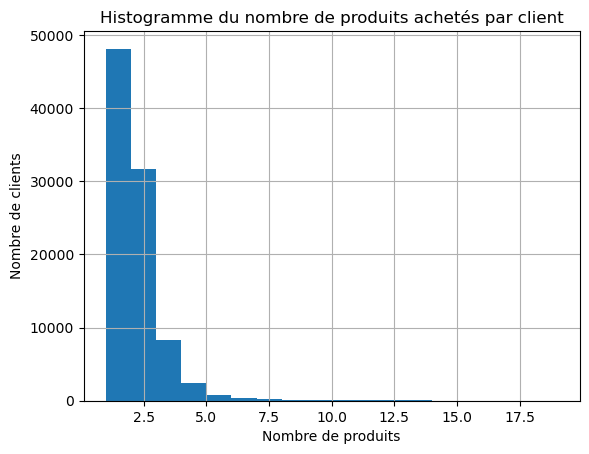

In [11]:
# Etude du nombre de produits achetés par chque client 

bins=np.arange(1,20)
df_X_train['Nb_of_items'].hist(bins=bins)

plt.title('Histogramme du nombre de produits achetés par client')
plt.xlabel('Nombre de produits')
plt.ylabel('Nombre de clients')

plt.show()

Text(0.5, 1.0, "Nombre d' items différents acheté par chaque clients")

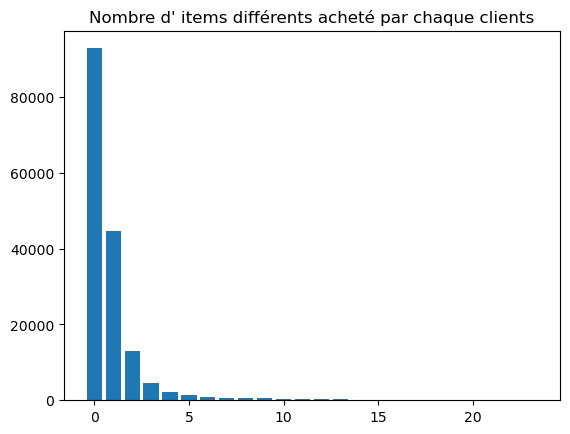

In [12]:
# Etude du nombre de produits différents achetés par chque client 

nb_NaN=df_X_train.isnull().sum()
nbr_items=nb_NaN[1:25]
nbr_items=92790-nbr_items
labels=np.arange(24)
plt.bar(labels, nbr_items)
plt.title('Nombre d\' items différents acheté par chaque clients')

Ainsi, cette première analyse nous montre plusieurs choses. Le nombre de colonnes presque vides est substantiel. Cela s'explique car le dataset est fait de telle sorte qu'il y a une colonne par item différent acheté dans la limite de 24 articles différents. Ainsi, on remarque bien que la très grande majorité des clients ont acheté entre 1 et 3 articles différents. En fait, il y a même que 43 clients qui ont acheté 24 articles différents. Pour autant, cela ne représente pas forcément un "outlier". Sans plus amples analyses, on pourrait penser qu'un fraudeur qui sait que ce n'est pas lui qui paie achèterait plus d'articles

In [13]:
#On s'intéresse désormais aux marques priviligié par les consomateurs
counts = df_X_train.iloc[:, 50:73].apply(pd.Series.value_counts).sum(axis=1)
brands_df = pd.DataFrame({'brand': counts.index, 'count': counts.values})

# Calcule le pourcentage d'apparition de chaque marque
brands_df['percent'] = brands_df['count'] / len(df_X_train) * 100

brands_df.sort_values('percent', ascending=False, inplace=True)
brands_df = brands_df.set_index(brands_df.columns[0])

print("Le nombre de marques différentes est : " + str(brands_df.shape[0]))
brands_df


Le nombre de marques différentes est : 753


,count,percent
brand,,
RETAILER,45660.0,49.207889
APPLE,12641.0,13.623235
ANYDAY RETAILER,1958.0,2.110141
SAMSUNG,386.0,0.415993
LG,335.0,0.361030
...,...,...
CARHARTT WIP,1.0,0.001078
CARDS AGAINST HUMANITY,1.0,0.001078
LIDO,1.0,0.001078


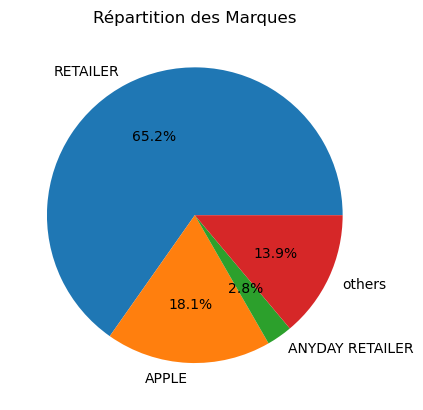

In [14]:
# Vers quelles marques se tourne le consomateur ? 

top_brands = counts.nlargest(3)

new_df = pd.DataFrame(top_brands)
new_df.index.name = 'Brand'
new_df.columns = ['Count']
other_count = counts.sum() - top_brands.sum()
new_df.loc['others'] = other_count

plt.pie(new_df.iloc[:,0],labels=new_df.index.map(str), autopct='%1.1f%%')
plt.title("Répartition des Marques")
plt.show()

In [15]:
#On s'intéresse désormais aux produits priviligié par les consomateurs
counts = df_X_train.iloc[:, 1:25].apply(pd.Series.value_counts).sum(axis=1)
product_df = pd.DataFrame({'Product': counts.index, 'count': counts.values})

# Calculer le pourcentage d'apparition de chaque produits
product_df['percent'] = product_df['count'] / len(df_X_train) * 100

product_df.sort_values('percent', ascending=False, inplace=True)
product_df = product_df.set_index(product_df.columns[0])

print("Le nombre de produits différents est : " + str(product_df.shape[0]))
product_df

Le nombre de produits différents est : 173


,count,percent
Product,,
COMPUTERS,50221.0,54.123289
FULFILMENT CHARGE,25023.0,26.967346
COMPUTER PERIPHERALS ACCESSORIES,17418.0,18.771419
TELEVISIONS HOME CINEMA,14051.0,15.142796
WARRANTY,8213.0,8.851169
...,...,...
HOME SAFETY EQUIPMENT,1.0,0.001078
MEN S SPORTSWEAR,1.0,0.001078
TECHNOLOGY ACCESSORIES,1.0,0.001078


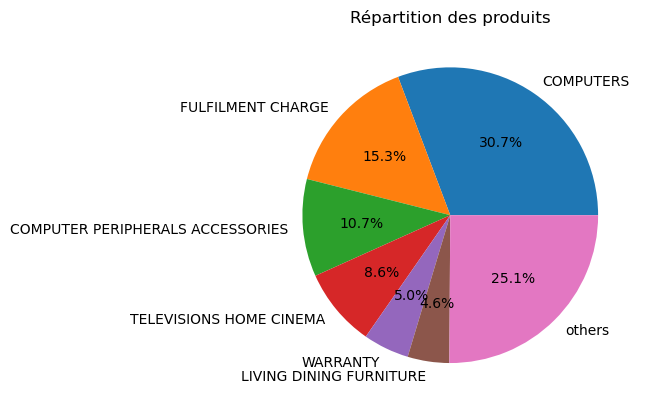

In [16]:
# Vers quel produit se tourne le consomateur ? 

top_product = counts.nlargest(6)

new_df = pd.DataFrame(top_product)
new_df.index.name = 'Product'
new_df.columns = ['Count']
other_count = counts.sum() - top_product.sum()
new_df.loc['others'] = other_count

plt.pie(new_df.iloc[:,0],labels=new_df.index.map(str), autopct='%1.1f%%')
plt.title("Répartition des produits")
plt.show()

Ainsi, nous remarquons qu'il y a 753 marques différentes pour 173 produits différents. Le premier point d'attention est que la marque principale est cataloguée comme "retailer", ce qui est en fait une sorte de marque indéfinie qui peut regrouper beaucoup de marques différentes réelles en son sein. Par conséquent, la marque la plus vendue est sans grande surprise Apple, et les produits les plus achetés sont les ordinateurs. Nous remarquons également l'apparition de "fulfillment charge". Ce terme regroupe beaucoup de frais indirects à une commande (création de site e-commerce, préparation de set up...).

Ce projet est proposé par BNP Personal Finance et regroupe donc les clients de plusieurs entités de crédits à la consommation. Ainsi, on peut supposer qu'un client "honnête" peut avoir tendance à avoir des fulfillment charge pour la création d'un site ou un lancement de projet, mais cela semble moins probable pour un fraudeur. Même constat pour les "warranty", un fraudeur ne prendra probablement pas de garanties à l'achat d'un produit car il ne sera pas amené à l'utiliser pour ne pas être démasqué. De plus, notre deuxième intuition est que les fraudeurs auront plus tendance à acheter des produits Apple que des produits de sous-marques. Nous essaierons de le vérifier ensuite en regardant les liens entre les variables de X et Y.

In [28]:
# on s'intéresse désormais aux pris dépensé par le clients
df_X_train.set_index('ID', inplace=True)

In [18]:
df_prix_item=df_X_train.iloc[:, 24:48]

df_prix_item
df_nbr_item=df_X_train.iloc[:, 120:144]
prod = df_nbr_item.to_numpy() * df_prix_item.to_numpy()
arr_no_nan = np.nan_to_num(prod, nan=0)
sum_prod = np.sum(arr_no_nan, axis=1)
df_prix_total = pd.DataFrame({'Prix total': sum_prod}, index=df_nbr_item.index)


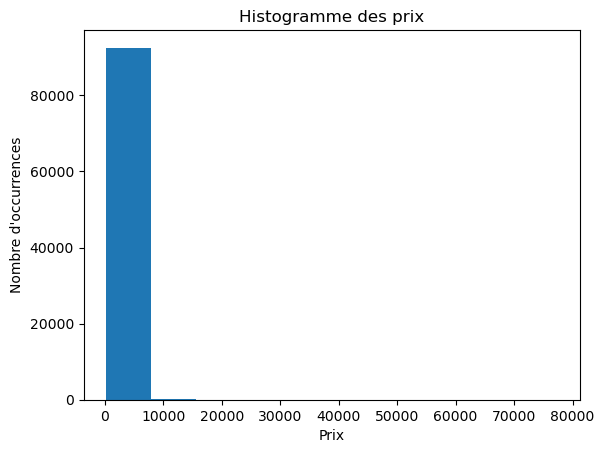

In [19]:
plt.hist(df_prix_total['Prix total'])

plt.xlabel('Prix')
plt.ylabel('Nombre d\'occurrences')
plt.title('Histogramme des prix')

plt.show()

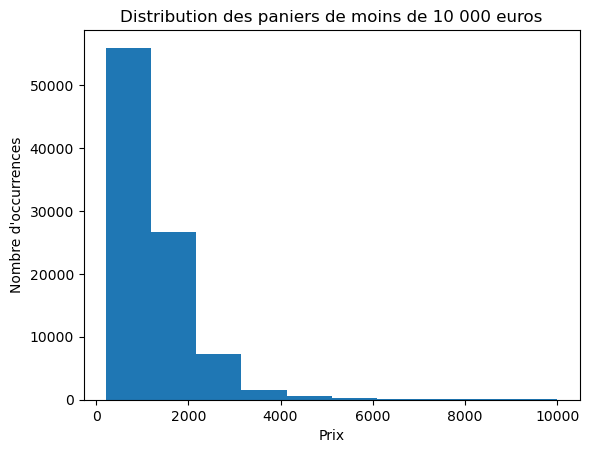

In [20]:
#intéressons nous à la distribution des prix inferieur à 10 000 euros désormais 
df_less_10000 = df_prix_total.loc[df_prix_total['Prix total'] < 10000]

plt.hist(df_less_10000['Prix total'])

plt.xlabel('Prix')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des paniers de moins de 10 000 euros')

plt.show()

In [21]:
moyenne_prix=df_prix_total['Prix total'].mean()
print("La moyenne des prix est : ", moyenne_prix)

La moyenne des prix est :  1295.3316844487551


Ainsi, il a été observé que la grande majorité des commandes sont inférieures à 10 000 euros, ce qui est cohérent avec un crédit à la consommation. En effet, les prix des paniers sont majoritairement inférieurs à 2000 euros, avec un panier moyen s'élevant à 1295 euros. Cette tendance est en corrélation avec le fait que les produits Apple, tels que les ordinateurs et les téléphones, soient les plus achetés et soient dans cette gamme de prix.

### Analyse de la variable de sortie Y et mise en relation avec celle d'entrée X

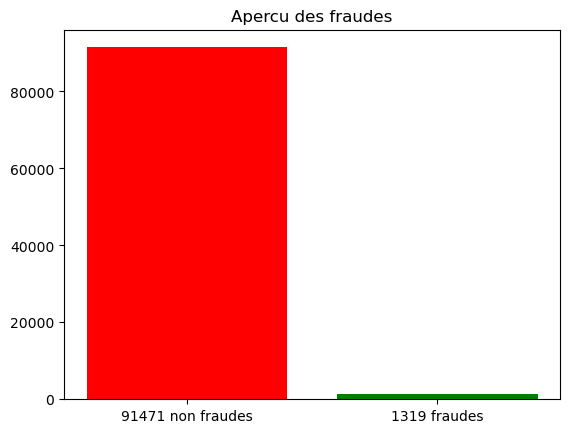

Pourcentage de fraudes reportés : 1.4214893846319647 %


In [29]:
# Etude du nombre de fraudes 
fraud_flags = df_Y_train['fraud_flag']
values, counts = np.unique(fraud_flags, return_counts=True)
lab_1=str(counts[0]) + " non fraudes"
lab_2=str(counts[1])+ " fraudes"
labels = [lab_1, lab_2]
colors = ['red', 'green']
plt.bar(labels, counts, color=colors)
plt.title(f"Apercu des fraudes")
plt.show()
print('Pourcentage de fraudes reportés :', 100*counts[1]/(counts[0]+counts[1]),'%')

In [30]:
df_Y_train.set_index('ID', inplace=True)

In [31]:
df_Y_train

,index,fraud_flag
ID,,
85517,0,0
51113,1,0
83008,2,0
78712,3,0
77846,4,0
...,...,...
21243,92785,0
45891,92786,0
42613,92787,0


In [32]:
df_nbr_items=df_X_train['Nb_of_items']
df_fraude=df_Y_train['fraud_flag']

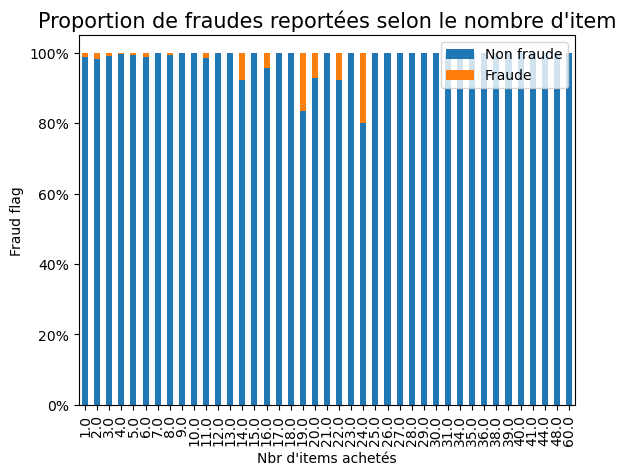

In [33]:
graphe=pd.crosstab(df_nbr_items, df_fraude)
graphe=graphe.div(graphe.sum(1), axis=0)
ax=graphe.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.legend(['Non fraude', 'Fraude'], loc='upper right')
plt.title('Proportion de fraudes reportées selon le nombre d\'item', fontsize=15)
plt.xlabel('Nbr d\'items achetés')
plt.ylabel('Fraud flag')
plt.show()

Cette première analyse est intéressante, car elle nous révèle que le nombre de fraudes signalées représente environ 20% des paniers comportant 24 articles. De plus, nous avons remarqué que le nombre de fraudes signalées pour les paniers contenant plus de 26 articles semble négligeable. Nous pouvons également constater que le nombre de fraudes est très faible par rapport aux non-fraudes : seulement 1,421%. C'est pourquoi nous utiliserons une technique d'undersampling avant de procéder à l'entraînement de nos modèles.

In [34]:
#Afin d'avoir une vue un peu plus globale sur les relations entre marques et fraudes 
#nous allons réalisé un tableau de contingence
df_marques=df_X_train.iloc[:, 48:72]

def get_top_brand(row):
    if 'APPLE' in row.values:
        return 'Apple'
    elif 'SAMSUNG' in row.values:
        return 'Samsung'
    elif 'LG' in row.values:
        return 'LG'
    elif 'RETAILER' in row.values:
        return 'Retailer'
    else:
        return 'Others'

new_df_marques = df_marques.apply(get_top_brand, axis=1).rename("Marques")


tableau_contingence=pd.DataFrame( pd.crosstab(new_df_marques, 
                                 df_fraude,  
                                 margins = True) ) 
tableau_contingence

fraud_flag,0,1,All
Marques,,,
Apple,63208,1191,64399
LG,8190,17,8207
Others,6173,24,6197
Retailer,9213,24,9237
Samsung,4687,63,4750
All,91471,1319,92790


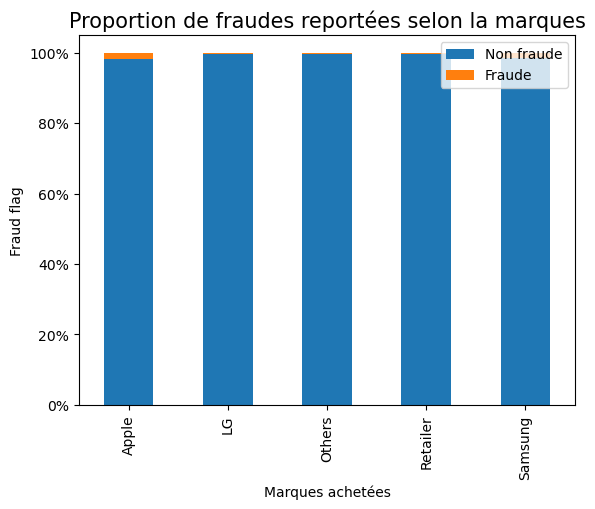

In [35]:
graphe=pd.crosstab(new_df_marques,df_fraude)
graphe=graphe.div(graphe.sum(1), axis=0)
ax=graphe.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.legend(['Non fraude', 'Fraude'], loc='upper right')
plt.title('Proportion de fraudes reportées selon la marques', fontsize=15)
plt.xlabel('Marques achetées')
plt.ylabel('Fraud flag')
plt.show()

Ce qui est intéressant à voir, c'est qu'il semble y avoir plus de fraudes avec au moins un produit Apple ou Samsung. Même si les proportions sont très faibles, cela donne déjà une belle indication. Les variables 'marques' jouent donc probablement un rôle. Les proportions sont plus faibles pour les "retailers", qui sont donc probablement moins visés par les escrocs

In [36]:
df_produits=df_X_train.iloc[:, 0:1]

def get_top_prod(row):
    if 'COMPUTERS' in row.values:
        return 'COMPUTERS'
    elif 'FULFILMENT CHARGE' in row.values:
        return 'FULFILMENT CHARGE '
    elif 'COMPUTER PERIPHERALS ACCESSORIES' in row.values:
        return 'COMPUTER PERIPHERALS ACCESSORIES'
    elif 'TELEVISIONS HOME CINEMA' in row.values:
        return 'TELEVISIONS HOME CINEMA '
    else:
        return 'Others'

new_df_produits = df_produits.apply(get_top_prod, axis=1).rename("Produits")

#new_df_produits = df_produits
tableau_contingence2=pd.DataFrame( pd.crosstab(new_df_produits, 
                                 df_fraude,  
                                 margins = True) ) 
tableau_contingence2

fraud_flag,0,1,All
Produits,,,
COMPUTER PERIPHERALS ACCESSORIES,11751,36,11787
COMPUTERS,46370,1066,47436
Others,19969,168,20137
TELEVISIONS HOME CINEMA,13381,49,13430
All,91471,1319,92790


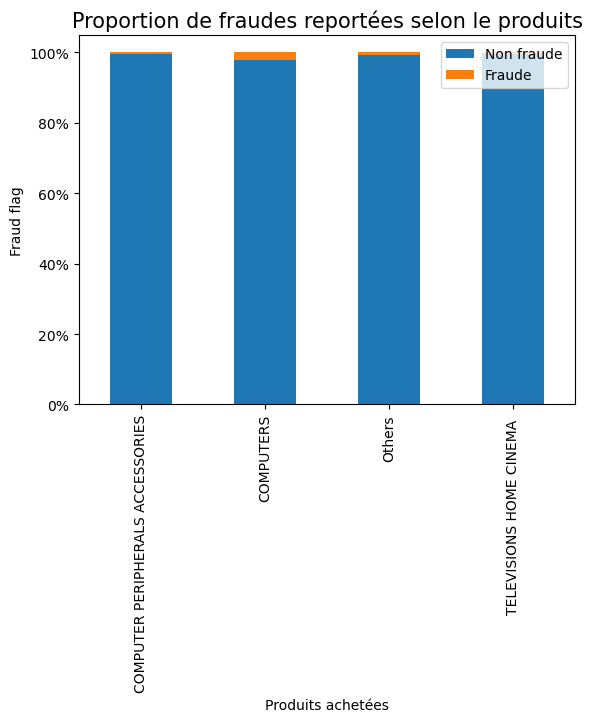

In [37]:
graphe=pd.crosstab(new_df_produits,df_fraude)
graphe=graphe.div(graphe.sum(1), axis=0)
ax=graphe.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.legend(['Non fraude', 'Fraude'], loc='upper right')
plt.title('Proportion de fraudes reportées selon le produits', fontsize=15)
plt.xlabel('Produits achetées')
plt.ylabel('Fraud flag')
plt.show()

De la même façon que pour les marques, nous constatons que les produits qui sont le plus sujets à la fraude sont les ordinateurs. Cela confirme nos précédentes intuitions

## 3. Statistiques descriptives & Data cleaning

Dans cette partie, nous allons tout d'abord effectuer quelques analyses statistiques sur notre jeu de données sachant que nous avons affaire à des variables qualitatives. Ensuite, nous allons procéder à une transformation de notre jeu de données afin de le rendre utilisable pour nos modèles.

In [38]:
# commencons par regarder l'argent dépenser selon le nombre d'articles
df_prix_item.describe()

,cash_price1,cash_price2,cash_price3,cash_price4,cash_price5,cash_price6,cash_price7,cash_price8,cash_price9,cash_price10,...,cash_price15,cash_price16,cash_price17,cash_price18,cash_price19,cash_price20,cash_price21,cash_price22,cash_price23,cash_price24
count,92790.000000,44656.000000,12901.000000,4562.000000,2170.00000,1336.000000,946.000000,727.000000,568.000000,472.00000,...,193.000000,165.000000,142.000000,120.000000,103.000000,91.000000,77.000000,63.000000,50.000000,43.000000
mean,1093.907124,191.608071,193.334548,176.132398,195.73871,162.015719,144.598309,130.957359,132.609155,111.57839,...,72.383420,98.230303,89.014085,83.958333,88.184466,79.615385,58.194805,125.777778,108.540000,121.744186
std,711.172270,392.665621,375.676640,321.354938,374.22739,292.077355,291.432858,257.730692,267.234057,213.05103,...,106.357486,227.905699,177.078097,133.670132,142.225018,222.555699,88.780041,341.952102,198.611734,263.623477
min,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,4.000000
25%,649.000000,7.000000,7.000000,10.000000,16.00000,15.000000,20.000000,16.000000,18.000000,15.00000,...,13.000000,16.000000,14.250000,12.000000,18.000000,13.000000,9.000000,12.000000,12.250000,9.000000
50%,949.000000,40.000000,43.000000,48.000000,59.00000,50.000000,50.000000,45.000000,45.000000,40.00000,...,35.000000,35.000000,30.000000,25.000000,36.000000,26.000000,25.000000,28.000000,35.000000,20.000000
75%,1349.000000,139.000000,189.000000,189.000000,199.00000,179.250000,140.000000,120.000000,129.250000,96.00000,...,72.000000,80.000000,89.500000,102.000000,95.500000,55.000000,54.000000,72.000000,86.750000,69.500000
max,21995.000000,6499.000000,5999.000000,5198.000000,4249.00000,2997.000000,4198.000000,2999.000000,2399.000000,1545.00000,...,599.000000,1599.000000,1550.000000,799.000000,999.000000,2010.000000,450.000000,2090.000000,995.000000,1045.000000


In [39]:
df_prix_total.describe()

,Prix total
count,92790.000000
mean,1295.331684
std,1075.861734
min,219.000000
25%,781.000000
50%,1099.000000
75%,1528.000000
max,77355.000000


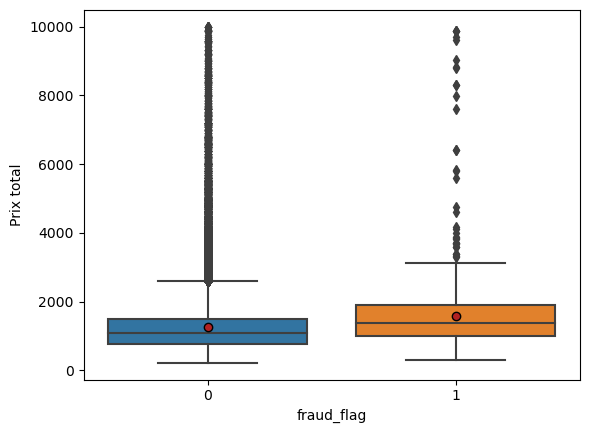

In [41]:
# Création d'une boite à moustache pour voir la difference de distribution des prix entre fraudes et non fraudes
df_prix_fraude=df_prix_total.join(df_fraude,how='inner')
df_prix_fraude = df_prix_fraude.loc[df_prix_fraude['Prix total'] < 10000]
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'} 
sns.boxplot(y='Prix total', x='fraud_flag', data=df_prix_fraude, showmeans=True, meanprops=meanprops) 
plt.show()

On remarque donc que les prix totaux ont l'air légèrement inférieurs pour les cas de non fraudes, néanmoins, y a-t-il un lien direct entre les deux variables ? Les moyennes (point rouge) ne semblent pas réellement différentes. Nous aimerions bien savoir si le prix total dépensé par le client est une variable qui joue en termes statistiques sur la variable cible. Ici, nous comparons des variables qualitatives et quantitatives. Faire une corrélation de type Pearson n'a que peu de sens dans ce cas. Afin de vérifier si le prix et la fraude sont liés, nous allons effectuer un test de Mann-Whitney, qui est un test non paramétrique utilisé pour comparer les moyennes de deux échantillons.

In [31]:
df_prix_fraude = df_prix_fraude.loc[df_prix_fraude['Prix total'] < 10000]

In [32]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df_prix_fraude['Prix total'], df_prix_fraude['fraud_flag'], alternative='two-sided')

# Afficher le résultat
print('Statistique de test :', stat)
print('Valeur p :', p)

Statistique de test : 8588470276.0
Valeur p : 0.0


La p value est très faible (0,0), ce qui suggère que les différences observées sont très peu probablement dues au hasard. On peut donc conclure que le prix est une variable significative pour prédire les fraudes c'est pour cela qu'on va donner une place importante aux prix dans la construction du dataset.

In [43]:
df_nbr_items=df_nbr_items.to_frame()
df_nbr_items.describe()

,Nb_of_items
count,92790.000000
mean,1.764479
std,1.462264
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,60.000000


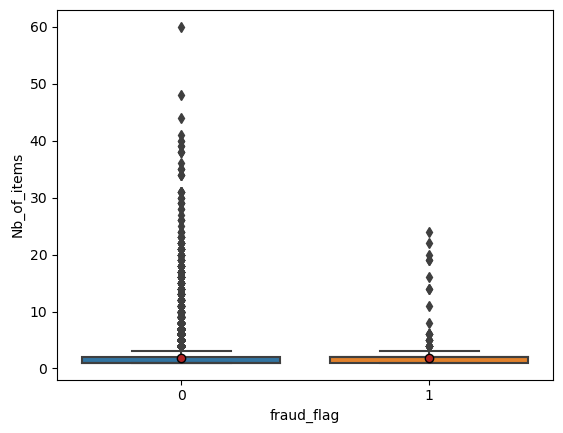

In [44]:
# boite à moustache du nombre d'items et fraude/non-fraude
df_item_fraude=df_nbr_items.join(df_fraude,how='inner')

meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'} 
sns.boxplot(y='Nb_of_items', x='fraud_flag', data=df_item_fraude, showmeans=True, meanprops=meanprops) 
plt.show()

Contrairement à se qu'on pouvait penser le nombre d'items ne sembles pas différés du tout entre fraudes et non fraudes. 


Nous allons désormais nettoyer le dataset et le mettre au format souhaité pour nos modèles. Tout d'abord, nous allons enlever les colonnes que nous jugeons inutiles, à savoir :

- goods_code
- model
- ID
- Nb_of_items

Ces quatre colonnes sont redondantes avec d'autres colonnes (model et Nb_of_items) ou tout simplement inutiles (goods_code).
Au vu des analyses précédentes, nous décidons de garder et de réarranger les colonnes afin de passer les marques et les types de produits en colonnes avec la quantité achetée, mais aussi de faire deux autres colonnes avec les marques et les types de produits et le prix qu'ils ont coûté. Avec un tel dataset, nous gardons les éléments clés tels que le prix dépensé, les marques et les types de produits visés, ainsi que la quantité de ces produits.

Le code prend du temps à s'exécuter pour la construction du dataset, etant donné le grand nombre de colonnes considérées.

In [5]:
# Load the dataset from a CSV file
df = pd.read_csv('X_train_G3tdtEn.csv')

# Get the data types of all columns
dtypes = df.dtypes

cols = df.columns

for col in cols:
    if "goods_code" in col or "model" in col or "ID" in col or col == 'Nb_of_items':
        df.drop(col, axis=1, inplace=True)

cols = df.columns

df.fillna('', inplace=True)

df.head()

,item1,item2,item3,item4,item5,item6,item7,item8,item9,item10,...,Nbr_of_prod_purchas15,Nbr_of_prod_purchas16,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24
0,COMPUTERS,,,,,,,,,,...,,,,,,,,,,
1,COMPUTER PERIPHERALS ACCESSORIES,,,,,,,,,,...,,,,,,,,,,
2,TELEVISIONS HOME CINEMA,,,,,,,,,,...,,,,,,,,,,
3,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,,,,,,,,,...,,,,,,,,,,
4,TELEVISIONS HOME CINEMA,,,,,,,,,,...,,,,,,,,,,


In [6]:
unique_values = {}
feature_cols = {}
feature_df = {}
features = ['item', 'price', 'make', 'purchas']

for feature in features:
    unique_values[feature] = []
    feature_cols[feature] = []
    
    for col in cols:
        if feature in col:
            feature_cols[feature].append(col)
    
    feature_df[feature] = df[feature_cols[feature]]
        
    if feature == 'item' or feature == 'make':  
        
        feature_df[feature] = feature_df[feature].apply(lambda x: x.str.replace(' ', ''))
        
        for i, row in feature_df[feature].iterrows():
            for val in row:
                if val != '':
                    if val not in unique_values[feature]:
                        unique_values[feature].append(val)
                        
print(unique_values)

{'item': ['COMPUTERS', 'COMPUTERPERIPHERALSACCESSORIES', 'TELEVISIONSHOMECINEMA', 'SERVICE', 'FULFILMENTCHARGE', 'CABLESADAPTERS', 'BEDROOMFURNITURE', 'LIVING&DININGFURNITURE', 'LIVINGDININGFURNITURE', 'WARRANTY', 'COMPUTERPERIPHERALS&ACCESSORIES', 'TELEPHONES,FAXMACHINES&TWO-WAYRADIOS', 'BABY&CHILDTRAVEL', 'TELEPHONESFAXMACHINESTWO-WAYRADIOS', 'STANDSBRACKETS', 'HOMEOFFICE', 'TELEVISIONS&HOMECINEMA', 'LIGHTING', 'OUTDOORFURNITURE', 'SOFTFURNISHINGS', 'AUDIOACCESSORIES', 'BATHROOMACCESSORIES', 'TABLEWARE', 'WINDOWDRESSING', 'BARBECUES&ACCESSORIES', 'OUTDOORACCESSORIES', 'POWERBATTERIES', 'BEDLINEN', 'BABYCHILDTRAVEL', 'HEALTHBEAUTYELECTRICAL', 'BAGSCARRYCASES', 'HOUSEHOLDCLEANING', 'BARBECUESACCESSORIES', 'FOODPREPARATION', 'COOKWARE', 'HI-FI', 'CABLES&ADAPTERS', 'CARPETSRUGSFLOORING', 'STORAGEORGANISATION', 'BATHLINEN', 'KITCHENUTENSILSGADGETS', 'DECORATIVEACCESSORIES', 'DECORATING', 'POWER&BATTERIES', 'HEATING&COOLINGAPPLIANCES', 'KITCHENSTORAGE', 'LAUNDRYCLOTHESCARE', 'BABYFEEDING',

In [7]:
new_cols = []

for feature in features:
    if feature == 'item' or feature == 'make':       
        for label_add_up in [' Number', ' Price']:
            for val in unique_values[feature]:
                new_cols.append(val + label_add_up)

new_cols

['COMPUTERS Number',
 'COMPUTERPERIPHERALSACCESSORIES Number',
 'TELEVISIONSHOMECINEMA Number',
 'SERVICE Number',
 'FULFILMENTCHARGE Number',
 'CABLESADAPTERS Number',
 'BEDROOMFURNITURE Number',
 'LIVING&DININGFURNITURE Number',
 'LIVINGDININGFURNITURE Number',
 'WARRANTY Number',
 'COMPUTERPERIPHERALS&ACCESSORIES Number',
 'TELEPHONES,FAXMACHINES&TWO-WAYRADIOS Number',
 'BABY&CHILDTRAVEL Number',
 'TELEPHONESFAXMACHINESTWO-WAYRADIOS Number',
 'STANDSBRACKETS Number',
 'HOMEOFFICE Number',
 'TELEVISIONS&HOMECINEMA Number',
 'LIGHTING Number',
 'OUTDOORFURNITURE Number',
 'SOFTFURNISHINGS Number',
 'AUDIOACCESSORIES Number',
 'BATHROOMACCESSORIES Number',
 'TABLEWARE Number',
 'WINDOWDRESSING Number',
 'BARBECUES&ACCESSORIES Number',
 'OUTDOORACCESSORIES Number',
 'POWERBATTERIES Number',
 'BEDLINEN Number',
 'BABYCHILDTRAVEL Number',
 'HEALTHBEAUTYELECTRICAL Number',
 'BAGSCARRYCASES Number',
 'HOUSEHOLDCLEANING Number',
 'BARBECUESACCESSORIES Number',
 'FOODPREPARATION Number',
 'CO

In [8]:
count_item = {}
count_make = {}
price_item = {}
price_make = {}

for i, row in feature_df['item'].iterrows():
    count_item[i] = {}
    price_item[i] = {}
    
    for item in unique_values['item']:
        count_item[i][f'{item} Number'] = 0
        price_item[i][f'{item} Price'] = 0
    
    for index, val in row.iteritems():
        if val != '':
            i_th = re.sub("[^0-9]", "", index)
            count_item[i][f'{val} Number'] += float(feature_df['purchas'][f'Nbr_of_prod_purchas{i_th}'][i])
            price_item[i][f'{val} Price'] += float(feature_df['price'][f'cash_price{i_th}'][i])


In [9]:
for i, row in feature_df['make'].iterrows():
    count_make[i] = {}
    price_make[i] = {}
    
    for make in unique_values['make']:
        count_make[i][f'{make} Number'] = 0
        price_make[i][f'{make} Price'] = 0
    
    for index, val in row.iteritems():
        if val != '':
            i_th = re.sub("[^0-9]", "", index)
            count_make[i][f'{val} Number'] += float(feature_df['purchas'][f'Nbr_of_prod_purchas{i_th}'][i])
            price_make[i][f'{val} Price'] += float(feature_df['price'][f'cash_price{i_th}'][i])

In [10]:
df_count_item = pd.DataFrame.from_dict(count_item, orient='index')

df_count_item.head()

,COMPUTERS Number,COMPUTERPERIPHERALSACCESSORIES Number,TELEVISIONSHOMECINEMA Number,SERVICE Number,FULFILMENTCHARGE Number,CABLESADAPTERS Number,BEDROOMFURNITURE Number,LIVING&DININGFURNITURE Number,LIVINGDININGFURNITURE Number,WARRANTY Number,...,2HPELITEBOOK850V6 Number,"2MICROSOFTOFFICEHOMEANDSTUDENT2019, Number",2TARGUSGEOLITEESSENTIALCASE Number,2LOGITECHPEBBLEM350BLUETOOTHMOUSE Number,APPLES Number,BLANKMEDIA&MEDIASTORAGE Number,PRODUCT Number,TECHNOLOGYACCESSORIES Number,HOMESAFETYEQUIPMENT Number,HEALTHBEAUTYACCESSORIES Number
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_price_item = pd.DataFrame.from_dict(price_item, orient='index')

df_price_item.head()

,COMPUTERS Price,COMPUTERPERIPHERALSACCESSORIES Price,TELEVISIONSHOMECINEMA Price,SERVICE Price,FULFILMENTCHARGE Price,CABLESADAPTERS Price,BEDROOMFURNITURE Price,LIVING&DININGFURNITURE Price,LIVINGDININGFURNITURE Price,WARRANTY Price,...,2HPELITEBOOK850V6 Price,"2MICROSOFTOFFICEHOMEANDSTUDENT2019, Price",2TARGUSGEOLITEESSENTIALCASE Price,2LOGITECHPEBBLEM350BLUETOOTHMOUSE Price,APPLES Price,BLANKMEDIA&MEDIASTORAGE Price,PRODUCT Price,TECHNOLOGYACCESSORIES Price,HOMESAFETYEQUIPMENT Price,HEALTHBEAUTYACCESSORIES Price
0,889.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,409.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1399.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,689.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_count_make = pd.DataFrame.from_dict(count_make, orient='index')

df_count_make.head()

,APPLE Number,SAMSUNG Number,SONY Number,RETAILER Number,LG Number,BUGABOO Number,PANASONIC Number,SWYFT Number,HERMANMILLER Number,HYPNOS Number,...,LOLAROSE Number,BONDS Number,LEAPFROG Number,MADEBYZEN Number,EUFY Number,GEORGJENSEN Number,MINIMODERNS Number,FLORENCEBROADHURST Number,ALADDIN Number,TATE Number
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_price_make = pd.DataFrame.from_dict(price_make, orient='index')

df_price_make.head()

,APPLE Price,SAMSUNG Price,SONY Price,RETAILER Price,LG Price,BUGABOO Price,PANASONIC Price,SWYFT Price,HERMANMILLER Price,HYPNOS Price,...,LOLAROSE Price,BONDS Price,LEAPFROG Price,MADEBYZEN Price,EUFY Price,GEORGJENSEN Price,MINIMODERNS Price,FLORENCEBROADHURST Price,ALADDIN Price,TATE Price
0,889.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,409.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1399.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,808.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
data = pd.concat([df_count_item, df_price_item, df_count_make, df_price_make], axis=1)

data.head()

,COMPUTERS Number,COMPUTERPERIPHERALSACCESSORIES Number,TELEVISIONSHOMECINEMA Number,SERVICE Number,FULFILMENTCHARGE Number,CABLESADAPTERS Number,BEDROOMFURNITURE Number,LIVING&DININGFURNITURE Number,LIVINGDININGFURNITURE Number,WARRANTY Number,...,LOLAROSE Price,BONDS Price,LEAPFROG Price,MADEBYZEN Price,EUFY Price,GEORGJENSEN Price,MINIMODERNS Price,FLORENCEBROADHURST Price,ALADDIN Price,TATE Price
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from imblearn.under_sampling import RandomUnderSampler

In [64]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

In [65]:
labels = pd.read_csv('Y_train_2_XPXJDyy.csv')

labels.drop(['ID', 'index'], axis = 1, inplace = True)

Y_train = labels.iloc[X_train.index]
Y_test = labels.iloc[X_test.index]

# Create an instance of RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

In [66]:
# Undersample the training data
X_train, Y_train = undersampler.fit_resample(X_train, Y_train)

In [67]:
# Create a LogisticRegression instance
logi_reg = LogisticRegression(random_state=42)

In [68]:
# Fit the model to the training data
logi_reg.fit(X_train, Y_train)

LogisticRegression(random_state=42)

In [69]:
# Make predictions on the test data
y_pred = logi_reg.predict_proba(X_test)[:, 1]

In [70]:
temp = pd.read_csv('Y_train_2_XPXJDyy.csv')

y_pred_proba = pd.DataFrame()
y_pred_proba['ID'] = temp.loc[X_test.index, 'ID'].values

y_pred_proba['y_pred'] = y_pred

y_true = pd.DataFrame()
y_true = temp.loc[Y_test.index, ['ID', 'fraud_flag']]

y_true.head()

,ID,fraud_flag
46180,107424,0
25031,74645,0
32798,102653,0
38656,23831,0
16271,60691,0


In [71]:
def pr_auc_score(y_true, y_pred_proba):
    ''' 
    Return the area under the Precision-Recall curve.
    
    Args:
        - y_true (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the ground truth observations (second column).
        - y_pred_proba (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the predicted probabilities estimates for the minority class (second column).
        
    Returns:
        float
    '''
    
    y_true_sorted = y_true.sort_values(by='ID').reset_index(drop=True)
    y_pred_proba_sorted = y_pred_proba.sort_values(by='ID').reset_index(drop=True)
    pr_auc_score = average_precision_score(np.ravel(y_true_sorted.iloc[:, 1]), np.ravel(y_pred_proba_sorted.iloc[:, 1]))

    return pr_auc_score

pr_auc = pr_auc_score(y_true, y_pred_proba)

print(f'PR-AUC: {pr_auc}')

PR-AUC: 0.043645590714420084


In [80]:
y_real = Y_test['fraud_flag'].to_list()

P_true_1 = 0.0
P_false_1 = 0.0
P_true_0 = 0.0
P_false_0 = 0.0

for i in range(len(y_pred)):
    if y_pred[i] >= 0.5 and y_real[i] == 1:
        P_true_1 += 1
    elif y_pred[i] < 0.5 and y_real[i] == 1:
        P_false_1 += 1
    elif y_pred[i] < 0.5 and y_real[i] == 0:
        P_true_0 += 1
    else:
        P_false_0 += 1
        
ones = len(y_pred[y_pred >= 0.5])
zeros = len(y_pred[y_pred < 0.5])
        
P_true_1 = P_true_1 / ones
P_false_1 = P_false_1 / zeros
P_true_0 = P_true_0 / zeros
P_false_0 = P_false_0 / ones

print(f'P_true_1 = {P_true_1}')
print(f'P_false_1 = {P_false_1}')
print(f'P_true_0 = {P_true_0}')
print(f'P_false_0 = {P_false_0}')

P_true_1 = 0.025135586149353357
P_false_1 = 0.0034559643255295427
P_true_0 = 0.9965440356744705
P_false_0 = 0.9748644138506466


In [81]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, GridSearchCV

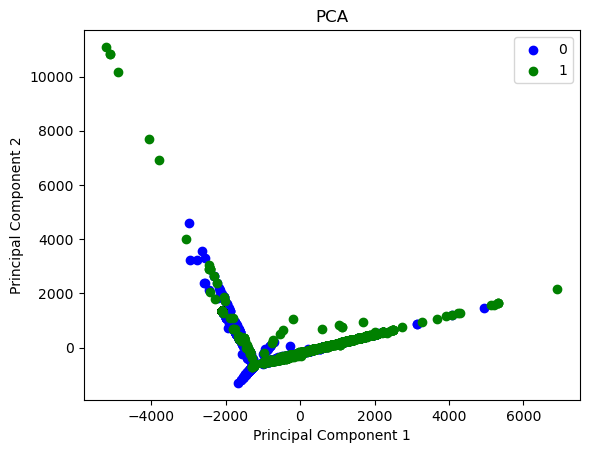

In [82]:
# Perform PCA
pca = PCA(n_components=2)  # Specify the desired number of components (2 for 2D plot)
X_pca = pca.fit_transform(X_train)

# Plotting
unique_labels = np.unique(Y_train)
colors = ['b', 'g']  # Adjust the colors as per the number of labels
for label, color in zip(unique_labels, colors):
    indices = np.where(Y_train == label)
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=color, label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.legend()
plt.show()

In [83]:
# Create an SVM classifier with rbf kernel
classifier = SVC(kernel='rbf')

classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_test)

In [84]:
y_pred_proba = pd.DataFrame()
y_pred_proba['ID'] = temp.loc[X_test.index, 'ID'].values

y_pred_proba['y_pred'] = y_pred

y_true = pd.DataFrame()
y_true = temp.loc[Y_test.index, ['ID', 'fraud_flag']]

y_inf = y_pred_proba[y_pred_proba==np.nan]
y_pred_proba.head()

,ID,y_pred
0,107424,0
1,74645,1
2,102653,1
3,23831,0
4,60691,0


In [85]:
pr_auc = pr_auc_score(y_true, y_pred_proba)

print(f'PR-AUC: {pr_auc}')

PR-AUC: 0.02424050465661017


In [86]:
y_real = Y_test['fraud_flag'].to_list()

P_true_1 = 0.0
P_false_1 = 0.0
P_true_0 = 0.0
P_false_0 = 0.0

for i in range(len(y_pred)):
    if y_pred[i] >= 0.5 and y_real[i] == 1:
        P_true_1 += 1
    elif y_pred[i] < 0.5 and y_real[i] == 1:
        P_false_1 += 1
    elif y_pred[i] < 0.5 and y_real[i] == 0:
        P_true_0 += 1
    else:
        P_false_0 += 1
        
ones = len(y_pred[y_pred >= 0.5])
zeros = len(y_pred[y_pred < 0.5])
        
P_true_1 = P_true_1 / ones
P_false_1 = P_false_1 / zeros
P_true_0 = P_true_0 / zeros
P_false_0 = P_false_0 / ones

print(f'P_true_1 = {P_true_1}')
print(f'P_false_1 = {P_false_1}')
print(f'P_true_0 = {P_true_0}')
print(f'P_false_0 = {P_false_0}')

P_true_1 = 0.02629416598192276
P_false_1 = 0.004781352724374938
P_true_0 = 0.995218647275625
P_false_0 = 0.9737058340180772


In [87]:
from sklearn.cluster import KMeans

In [88]:
kmeans = KMeans(n_clusters=2)

# Fit the data to the KMeans model
kmeans.fit(X_train)

KMeans(n_clusters=2)

In [89]:
# Get the cluster labels for each data point
labels = kmeans.labels_

# Get the coordinates of the cluster centers
centroids = kmeans.cluster_centers_

y_pred = pd.DataFrame()

# Predict the cluster labels for the test data
y_pred = kmeans.predict(X_test)

In [90]:
y_pred_proba = pd.DataFrame()
y_pred_proba['ID'] = temp.loc[X_test.index, 'ID'].values

y_pred_proba['y_pred'] = y_pred

y_true = pd.DataFrame()
y_true = temp.loc[Y_test.index, ['ID', 'fraud_flag']]

y_inf = y_pred_proba[y_pred_proba==np.nan]
y_pred_proba.head()

,ID,y_pred
0,107424,1
1,74645,0
2,102653,0
3,23831,1
4,60691,1


In [91]:
pr_auc = pr_auc_score(y_true, y_pred_proba)

print(f'PR-AUC: {pr_auc}')

PR-AUC: 0.012055290591782342


In [93]:
y_real = Y_test['fraud_flag'].to_list()

P_true_1 = 0.0
P_false_1 = 0.0
P_true_0 = 0.0
P_false_0 = 0.0

for i in range(len(y_pred)):
    if y_pred[i] >= 0.5 and y_real[i] == 1:
        P_true_1 += 1
    elif y_pred[i] < 0.5 and y_real[i] == 1:
        P_false_1 += 1
    elif y_pred[i] < 0.5 and y_real[i] == 0:
        P_true_0 += 1
    else:
        P_false_0 += 1
        
ones = len(y_pred[y_pred >= 0.5])
zeros = len(y_pred[y_pred < 0.5])
        
P_true_1 = P_true_1 / ones
P_false_1 = P_false_1 / zeros
P_true_0 = P_true_0 / zeros
P_false_0 = P_false_0 / ones

print(f'P_true_1 = {P_true_1}')
print(f'P_false_1 = {P_false_1}')
print(f'P_true_0 = {P_true_0}')
print(f'P_false_0 = {P_false_0}')

P_true_1 = 0.008338917429826521
P_false_1 = 0.031207333723425004
P_true_0 = 0.968792666276575
P_false_0 = 0.9916610825701735


In [94]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

SyntaxError: invalid syntax (3237298704.py, line 1)

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Generate some dummy data (replace with your actual data)
train_images = np.random.random((1000, 64, 64, 3))
train_labels = np.random.randint(2, size=(1000, 1))
test_images = np.random.random((100, 64, 64, 3))
test_labels = np.random.randint(2, size=(100, 1))

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

# Make predictions on new data
new_data = np.random.random((10, 64, 64, 3))
predictions = model.predict(new_data)
print(predictions)

# AJOUT DEUXIEME DATASET ET COMPARAISON RESULTATS

In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
import re

In [5]:
df_X_train = pd.read_csv('X_train_G3tdtEn.csv')
df_Y_train = pd.read_csv('Y_train_2_XPXJDyy.csv')

In [6]:
df_X_train.set_index('ID', inplace=True)

In [7]:
cols = df_X_train.columns

for col in cols:
    if "goods_code" in col or "model" in col or "ID" in col :
        df_X_train.drop(col, axis=1, inplace=True)


In [8]:
df_prix_item=df_X_train.iloc[:, 24:48]
#df_prix_item.index=df_X_train.index
df_prix_item
df_nbr_item=df_X_train.iloc[:, 72:96]
prod = df_nbr_item.to_numpy() * df_prix_item.to_numpy()
arr_no_nan = np.nan_to_num(prod, nan=0)
sum_prod = np.sum(arr_no_nan, axis=1)
df_prix_total = pd.DataFrame({'Prix total': sum_prod}, index=df_nbr_item.index)

In [9]:
cols = df_X_train.columns

for col in cols:
    if "Nbr_of_prod_purchas" in col or "cash_price" in col or "ID" in col :
        df_X_train.drop(col, axis=1, inplace=True)

In [10]:
df_X_train=df_X_train.join(df_prix_total)


In [11]:
df=df_X_train.iloc[:, 24:48]
#df.fillna('', inplace=True)
brands_to_keep = ["APPLE", "RETAILER", "LG", "SAMSUNG", "SONY"]
#df = df.apply(lambda x: x if pd.isna(x) or x in brands_to_keep else "others")
df = np.where(df.isin(brands_to_keep) | pd.isna(df), df, "others")
type(df)

numpy.ndarray

In [12]:
df_final = pd.DataFrame(data=df, index=df_X_train.index, columns=df_X_train.iloc[:, 24:48].columns)


In [13]:
df=df_X_train.iloc[:, 0:24]
#df.fillna('', inplace=True)
product_to_keep = ["COMPUTERS", "FULFILMENT CHARGE", "COMPUTER PERIPHERALS ACCESSORIES", "TELEVISIONS HOME CINEMA", "WARRANTY"]
#df = df.apply(lambda x: x if pd.isna(x) or x in brands_to_keep else "others")
df = np.where(df.isin(brands_to_keep) | pd.isna(df), df, "others")
df_final2 = pd.DataFrame(data=df, index=df_X_train.index, columns=df_X_train.iloc[:, 0:24].columns)


In [14]:
cols = df_X_train.columns

for col in cols:
    if "item" in col or "make" in col or "ID" in col :
        if col !='Nb_of_items':
            df_X_train.drop(col, axis=1, inplace=True)

In [15]:
df_X_train=df_X_train.join(df_final2)

In [16]:
df_X_train=df_X_train.join(df_final)


In [17]:
dummies = pd.get_dummies(df_X_train[[
    'item1', 
    'item2', 
    'item3',
    'item4',
    'item5',
    'item6',
    'item7',
    'item8',
    'item9',
    'item10',
    'item11',
    'item12',
    'item13',
    'item14',
    'item15',
    'item16',
    'item17',
    'item18',
    'item19',
    'item20',
    'item21',
    'item22',
    'item23',
    'item24',
    'make1',
    'make2',
    'make3',
    'make4',
    'make5',
    'make6',
    'make7',
    'make8',
    'make9',
    'make10',
    'make11',
    'make12',
    'make13',
    'make14',
    'make15',
    'make16',
    'make17',
    'make18',
    'make19',
    'make20',
    'make21',
    'make22',
    'make23',
    'make24'
]])


In [18]:
df_new = df_X_train.loc[:, ['Nb_of_items', 'Prix total']]
df_train=df_new.join(dummies)

In [19]:
df_train_X=df_train.copy()

In [20]:
df_y_train=pd.read_csv("Y_train_2_XPXJDyy.csv")

In [21]:
df_y_train.set_index('ID', inplace=True)

In [22]:
df_y_train.drop('index', axis=1, inplace=True)

In [135]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train_X, df_y_train, train_size=0.8, random_state=42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of X_train and X_test:  74232 18558
length of y_train and y_test:  74232 18558


In [136]:
from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler(random_state=0)

X_train, y_train = rus.fit_resample(X_train, y_train)

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score

In [138]:
logi_reg = LogisticRegression(random_state=0)

In [139]:
logi_reg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [140]:
y_pred = logi_reg.predict_proba(X_test)[:, 1]

In [1]:
y_pred

NameError: name 'y_pred' is not defined

In [142]:
def pr_auc_score(y_true, y_pred_proba):
    ''' 
    Return the area under the Precision-Recall curve.
    
    Args:
        - y_true (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the ground truth observations (second column).
        - y_pred_proba (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the predicted probabilities estimates for the minority class (second column).
        
    Returns:
        float
    '''
    
    y_true_sorted = y_true.sort_values(by='ID').reset_index(drop=True)
    y_pred_proba_sorted = y_pred_proba.sort_values(by='ID').reset_index(drop=True)
    pr_auc_score = average_precision_score(np.ravel(y_true_sorted.iloc[:, 1]), np.ravel(y_pred_proba_sorted.iloc[:, 1]))

    return pr_auc_score

In [143]:
y_test

,fraud_flag
ID,
107424,0
74645,0
102653,0
23831,0
60691,0
...,...
96137,0
84464,0
62549,0


In [144]:
df = y_test.reset_index()
df1 = pd.DataFrame({ 
                    'ID': df['ID'], 
                    'pred_proba': y_pred})
df = df.rename(columns={'index': 'ID'})
pr_auc_score(df, df1)

0.03328127806620422

In [145]:
from sklearn.metrics import average_precision_score
auc_pr = average_precision_score(y_true=y_test, y_score=y_pred)
print(auc_pr)

0.03328127806620422


In [126]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [34]:
#clf = svm.SVC(kernel='linear', C=1)

In [127]:
# Create an SVM classifier with a radial basis function (rbf) kernel
classifier = svm.SVC(kernel='rbf',C=100)



In [128]:
# Fit the classifier to the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data


SVC(C=100)

In [129]:
y_pred = classifier.predict(X_test)

In [130]:
if np.all(y_pred == 0):
    print("Le vecteur ne contient que des 0.")
else:
    print("Le vecteur ne contient pas que des 0.")

Le vecteur ne contient pas que des 0.


In [ ]:
#clf.fit(X_train, y_train)

In [106]:
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Convert labels_test to binary class labels
#labels_test_binary = np.where(labels_test >= 0.5, 1, 0)

In [146]:
#clf = svm.SVC(kernel='linear', C=1)

#clf.fit(X_train, y_train)


#y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Afficher l'exactitude
print('Exactitude : {:.2f}%'.format(accuracy*100))



ValueError: Classification metrics can't handle a mix of binary and continuous targets